In [1]:
import numpy as np
import tensorflow as tf
import pickle
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

## open a image

In [4]:
image_path = './image/'

In [5]:
image_list = os.listdir(image_path)

In [6]:
im_test = Image.open(image_path + image_list[1])

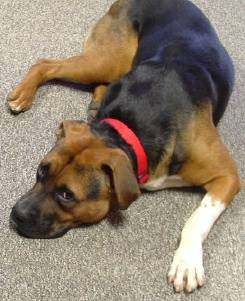

In [9]:
im_test

In [10]:
np.array(im_test).shape

(301, 245, 3)

** resize **

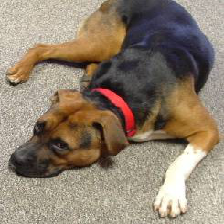

In [11]:
im_test.resize((224, 224), Image.NEAREST)

In [12]:
im_test.close()

In [13]:
image_list[0].split('.')[0] == 'dog'

True

## split the image

In [7]:
dogs_image=[]
cats_image=[]
for im in image_list:
    if(im.split('.')[0] == 'dog'):
        dogs_image.append(image_path+im)
    else:
        cats_image.append(image_path+im)

In [8]:
print('dogs image number:', len(dogs_image))
print('cats image number:', len(cats_image))

dogs image number: 12500
cats image number: 12500


## convert dogs images to array of numpy

In [9]:
dogs = []
for dog in dogs_image:
    try:
        tmp = Image.open(dog)
    except Exception:
        print('open fail for image:', dogs_image_list)
    else:
        dogs.append(np.array(tmp.resize((224, 224), Image.NEAREST)))
        tmp.close()

In [10]:
dogs = np.array(dogs)

In [11]:
dogs.shape

(12500, 224, 224, 3)

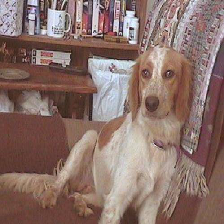

In [12]:
Image.fromarray(dogs[0])

In [14]:
with open('dogs.pickle', 'wb') as f:
    pickle.dump(dogs, f)
    f.close()

## convert cats images to array of numpy

In [23]:
cats = []
for cat in cats_image:
    try:
        tmp = Image.open(cat)
    except Exception:
        print('open fail for image:', cats_image_list)
    else:
        cats.append(np.array(tmp.resize((224, 224), Image.NEAREST)))
        tmp.close()

In [24]:
cats = np.array(cats)

In [25]:
cats.shape

(12500, 224, 224, 3)

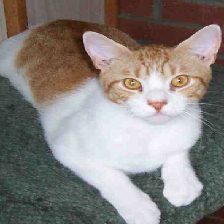

In [26]:
Image.fromarray(cats[0])

In [36]:
with open('cats.pickle', 'wb') as f:
    pickle.dump(cats, f)
    f.close()

## random the images

In [3]:
with open('dogs.pickle', 'rb') as f:
    dogs = pickle.load(f)
    f.close()

with open('cats.pickle', 'rb') as f:
    cats = pickle.load(f)
    f.close()

In [4]:
dogs_label = np.zeros([len(dogs), 1])
cats_label = np.ones([len(cats), 1])

In [5]:
index_list = list(range(0, len(dogs)+len(cats)))

In [6]:
random.shuffle(index_list)

In [7]:
dataset = np.concatenate([dogs, cats], axis=0)

In [8]:
dataset.shape

(25000, 224, 224, 3)

In [9]:
labels = np.concatenate([dogs_label, cats_label], axis=0)

In [10]:
labels.shape

(25000, 1)

In [13]:
del dogs, cats, dogs_label, cats_label,

In [14]:
dataset = dataset[index_list]
labels = labels[index_list]

In [15]:
del index_list

In [18]:
with open('dataset_labels.pickle1', 'wb') as f:
    pickle.dump([dataset[:10000], labels[:10000]], f)

In [19]:
with open('dataset_labels.pickle2', 'wb') as f:
    pickle.dump([dataset[10000:], labels[10000:]], f)

## split train, validation and test data

In [2]:
with open('dataset_labels.pickle1', 'rb') as f:
    dataset1, labels1 = pickle.load(f)
    f.close()

with open('dataset_labels.pickle2', 'rb') as f:
    dataset2, labels2 = pickle.load(f)
    f.close()

dataset = np.concatenate([dataset1, dataset2], axis = 0)
labels = np.concatenate([labels1, labels2], axis = 0)

In [3]:
del dataset1, dataset2, labels1, labels2

In [4]:
dataset.shape

(25000, 224, 224, 3)

In [5]:
labels.shape

(25000, 1)

In [6]:
train_data_num = int(len(dataset)*0.8)
val_data_num = int(len(dataset)*0.1)
train_data = dataset[:train_data_num]
train_label = labels[:train_data_num]
val_data = dataset[train_data_num:train_data_num+val_data_num]
val_label = labels[train_data_num:train_data_num+val_data_num]
test_data = dataset[train_data_num+val_data_num:]
test_label = labels[train_data_num+val_data_num:]

In [7]:
print("train data count:", len(train_data))
print("validation data count:", len(val_data))
print("test data count:", len(test_data))

train data count: 20000
validation data count: 2500
test data count: 2500


In [8]:
step = 0
for i in range(0, len(train_data), 2000):
    step = step + 1
    with open('data/train/train_dataset_labels_'+str(step)+'.pickle', 'wb') as f:
        pickle.dump([train_data[i:i+2000], train_label[i:i+2000]], f)
        f.close()
        
with open('data/val/val_dataset_labels.pickle', 'wb') as f:
    pickle.dump([val_data, val_label], f)
    f.close()
    
with open('data/test/test_dataset_labels.pickle', 'wb') as f:
    pickle.dump([test_data, test_label], f)
    f.close()

## Create a model

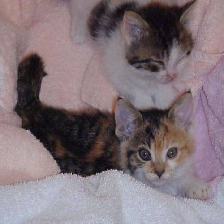

In [17]:
with open('data/train/train_dataset_labels_6.pickle', 'rb') as f:
    train_data, train_label = pickle.load(f)
    f.close()


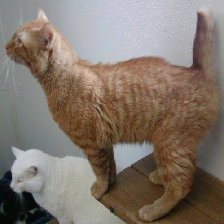

In [27]:
Image.fromarray(train_data[999])

In [28]:
train_label[999]

array([ 1.])

In [ ]:
del train_data, train_label

In [1]:
import numpy as np
import tensorflow as tf
import pickle
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import math

In [86]:
class cnn_model(object):
    def __init__(self, image_high, image_width, image_deep, log_dir = './tensorboard', model_dir = './model'):
        self.log_dir = log_dir
        self.model_dir = model_dir
        
        tf.reset_default_graph()
        self.learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
        self.keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')
        
        #224*224*3
        self.inputs = tf.placeholder(tf.float32, [None, image_high, image_width, image_deep], name="input")
        self.target = tf.placeholder(tf.float32, shape=[None, 1], name='target')
        
        conv2d_layer1 = tf.contrib.layers.conv2d(self.inputs, 64, 8, 4, 'SAME',
                            weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
        #56*56*64
        conv2d_layer1 = tf.contrib.layers.max_pool2d(conv2d_layer1, 4, 2, 'SAME')
        #28*28*64
        
        conv2d_layer2 = tf.contrib.layers.conv2d(conv2d_layer1, 128, 4, 2, 'SAME',
                            weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
        #14*14*128
        conv2d_layer2 = tf.contrib.layers.max_pool2d(conv2d_layer2, 4, 2, 'SAME')
        #7*7*128
        
        conv2d_layer3 = tf.contrib.layers.conv2d(conv2d_layer2, 256, 1, 1, 'SAME',
                            weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
        #7*7*256
        conv2d_layer3 = tf.contrib.layers.max_pool2d(conv2d_layer3, 4, 2, 'SAME')
        #4*4*256
        
        fc_layer1 = tf.contrib.layers.fully_connected(
                        tf.reshape(conv2d_layer3, [-1, 4*4*256]), 512,
                        weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
        fc_layer1 = tf.nn.dropout(fc_layer1, self.keep_prob)
        
        fc_layer2 = tf.contrib.layers.fully_connected(fc_layer1, 256,
                        weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
        fc_layer2 = tf.nn.dropout(fc_layer2, self.keep_prob)
        
        self.predictions = tf.contrib.layers.fully_connected(fc_layer2, 1, activation_fn=None,
                                weights_initializer=tf.truncated_normal_initializer(stddev=0.1))
        
        self.loss = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=self.predictions, labels=self.target))
        self.opt = tf.train.AdamOptimizer().minimize(self.loss)
        
        correct_pred = tf.equal(tf.round(tf.nn.sigmoid(self.predictions)), self.target)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
        
        tf.summary.scalar('lost', self.loss)
        tf.summary.scalar('accuracy', self.accuracy)
        
    def batch_generator(self, batch_size):
        train_data_packages = os.listdir('data/train/')
        for package in train_data_packages:
            with open('data/train/'+package, 'rb') as f:
                train_data, train_label = pickle.load(f)
                f.close()
            #print("pack:", package, "data shape:", train_data.shape)
            for i in range(0, len(train_data), batch_size):
                yield train_data[i:i+batch_size], train_label[i:i+batch_size]
        
    def train(self, epochs=1, batch_size = 128, learning_rate=0.01, 
              keep_prob=1.0, show_every_n_batches=50, re_train=True):
        step = 0
        global_step = 0
        losses = {'train':[], 'validation':[]}
        accuracy = {'train':[], 'validation':[]}
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        if re_train == False:
            saver.restore(sess, self.model_dir+'/model.ckpt')
            with open(self.model_dir+'/step.pickle', 'rb') as file:
                global_step = pickle.load(file)
                file.close()
            print('start record log from step of', global_step, 'in tensorboard')
        
        summary = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(self.log_dir+'/train',
                                      sess.graph)
        val_writer = tf.summary.FileWriter(self.log_dir+'/validation',
                                               sess.graph)
        
        with open('data/val/val_dataset_labels.pickle', 'rb') as f:
            val_data, val_label = pickle.load(f)
            f.close()
            
        with open('data/test/test_dataset_labels.pickle', 'rb') as f:
            test_data, test_label = pickle.load(f)
            f.close()
            
        for e in range(epochs):
            for x, y in self.batch_generator(batch_size):
                step = step + 1
                feed = {self.inputs: x,
                        self.target: y,
                        self.keep_prob: keep_prob,
                        self.learning_rate: learning_rate}
                train_loss,  _, train_accuracy, train_summary = sess.run(
                        [self.loss, self.opt, self.accuracy, summary], feed_dict=feed)
                
                if step%show_every_n_batches == 0:
                    train_writer.add_summary(train_summary, step + global_step)
                    
                    val_loss = 0
                    val_accuracy = 0
                    for i in range(0, len(val_data), batch_size):
                        feed = {self.inputs: val_data[i:i+batch_size],
                                self.target: val_label[i:i+batch_size],
                                self.keep_prob: 1}
                        loss_, acc, val_summary = sess.run(
                                [self.loss, self.accuracy, summary], feed_dict=feed)
                        val_loss = val_loss+loss_
                        val_accuracy = val_accuracy+acc
                        
                    val_loss = val_loss/math.ceil(len(val_data)/batch_size)
                    val_accuracy = val_accuracy/math.ceil(len(val_data)/batch_size)
                    val_writer.add_summary(val_summary, step + global_step)
                    
                    print("echop:", e,
                          "\ntrain loss: {:>6.4f}, accuracy: {:>6.4f}".format(train_loss, train_accuracy),
                          "validation loss: {:>6.4f}, accuracy: {:>6.4f}".format(val_loss, val_accuracy))
                    losses['train'].append(train_loss)
                    losses['validation'].append(val_loss)
                    accuracy['train'].append(train_accuracy)
                    accuracy['validation'].append(val_accuracy)
                    
                    saver.save(sess, self.model_dir+'/model.ckpt')
                    with open(self.model_dir+'/step.pickle', 'wb') as file:
                        pickle.dump(step + global_step, file)
                        file.close()
                        
        test_loss = 0
        test_accuracy = 0
        for i in range(0, len(test_data), batch_size):
            feed = {self.inputs: test_data[i:i+batch_size],
                    self.target: test_label[i:i+batch_size],
                    self.keep_prob: 1}
            loss_, acc = sess.run([self.loss, self.accuracy], feed_dict=feed)
            test_loss = test_loss+loss_
            test_accuracy = test_accuracy+acc
            
        test_loss = test_loss/math.ceil(len(test_data)/batch_size)
        test_accuracy = test_accuracy/math.ceil(len(test_data)/batch_size)
        print("test loss is:", test_loss,
              "\ntest accuracy is:", test_accuracy)
        
        saver.save(sess, self.model_dir+'/model.ckpt')
        with open(self.model_dir+'/step.pickle', 'wb') as file:
            pickle.dump(step + global_step, file)
            file.close()
                        
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title("loss record")
        plt.plot(losses['train'], label='Training loss')
        plt.plot(losses['validation'], label='Validation loss')
        plt.legend()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title("accuracy record")
        plt.plot(accuracy['train'], label='Training accuracy')
        plt.plot(accuracy['validation'], label='Validation accuracy')
        plt.legend()
        plt.show()
        
    def predict(self, input_image):
        with tf.Session() as sess:
            self.saver = tf.train.Saver()
            self.saver.restore(sess, self.model_dir+'/model.ckpt')
            
            feed = {self.inputs: input_image.reshape([1, 128, 128, 3]),
                    self.keep_prob: 1.0}
            predict_output = sess.run(self.predictions, feed_dict = feed)
            if(predict > 0.5):
                print("it's a cat")
            else:
                print("it's a dog")

In [87]:
rm -rf ./tensorboard/cnn_model/

In [88]:
dog_vs_cat_cnn_model = cnn_model(224, 224, 3, log_dir = './tensorboard/cnn_model', 
                                 model_dir = './model/cnn_model')

INFO:tensorflow:Restoring parameters from ./model/cnn_model/model.ckpt
start record log from step of 1600 in tensorboard
echop: 0 
train loss: 0.6266, accuracy: 0.7422 validation loss: 0.8547, accuracy: 0.6955
echop: 0 
train loss: 0.7794, accuracy: 0.6953 validation loss: 0.8351, accuracy: 0.7081
echop: 0 
train loss: 0.3865, accuracy: 0.8125 validation loss: 1.0223, accuracy: 0.6846
echop: 1 
train loss: 0.5939, accuracy: 0.7734 validation loss: 0.8789, accuracy: 0.7014
echop: 1 
train loss: 0.3661, accuracy: 0.8516 validation loss: 0.8769, accuracy: 0.6994
echop: 1 
train loss: 0.3134, accuracy: 0.8516 validation loss: 0.9414, accuracy: 0.6947
echop: 2 
train loss: 0.4159, accuracy: 0.7812 validation loss: 0.8630, accuracy: 0.7110
echop: 2 
train loss: 0.2210, accuracy: 0.9125 validation loss: 0.8011, accuracy: 0.7107
echop: 2 
train loss: 0.3833, accuracy: 0.8672 validation loss: 0.8536, accuracy: 0.6991
echop: 3 
train loss: 0.3003, accuracy: 0.8594 validation loss: 0.9586, accura

echop: 28 
train loss: 0.2550, accuracy: 0.9062 validation loss: 0.9503, accuracy: 0.7229
echop: 29 
train loss: 0.4493, accuracy: 0.8438 validation loss: 0.8295, accuracy: 0.7355
echop: 29 
train loss: 0.3022, accuracy: 0.8828 validation loss: 0.8843, accuracy: 0.7215
echop: 29 
train loss: 0.4966, accuracy: 0.8281 validation loss: 0.8771, accuracy: 0.7452
echop: 29 
train loss: 0.3190, accuracy: 0.8625 validation loss: 1.0411, accuracy: 0.6935
echop: 30 
train loss: 0.3937, accuracy: 0.7969 validation loss: 0.8616, accuracy: 0.7197
echop: 30 
train loss: 0.2616, accuracy: 0.8672 validation loss: 0.9084, accuracy: 0.7466
echop: 30 
train loss: 0.3158, accuracy: 0.8594 validation loss: 0.9214, accuracy: 0.7403
echop: 31 
train loss: 0.3214, accuracy: 0.8828 validation loss: 1.2607, accuracy: 0.7036
echop: 31 
train loss: 0.2800, accuracy: 0.8828 validation loss: 0.7794, accuracy: 0.7490
echop: 31 
train loss: 0.2518, accuracy: 0.8828 validation loss: 0.9590, accuracy: 0.7233
echop: 32 

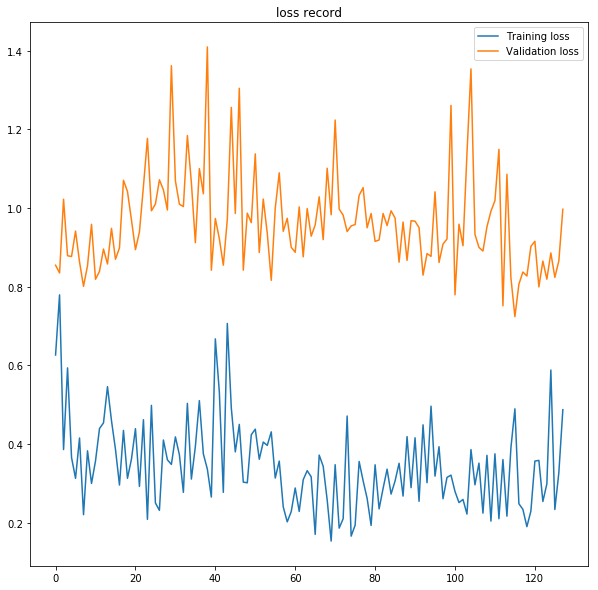

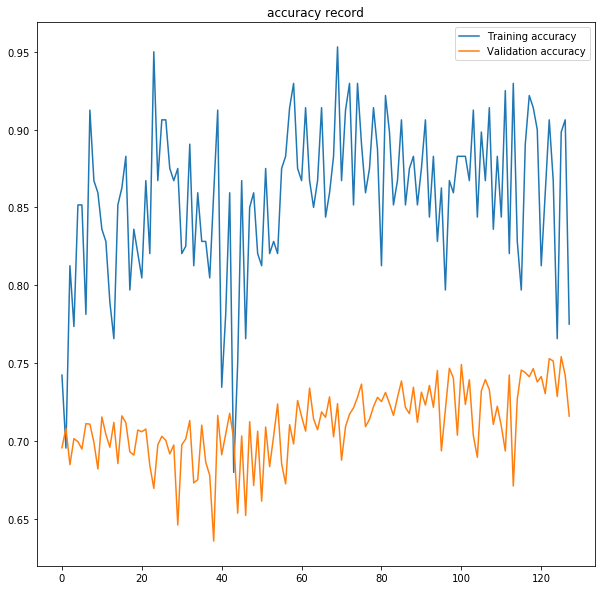

In [91]:
dog_vs_cat_cnn_model.train(epochs = 40, batch_size = 128, re_train=False, keep_prob=1)

## Build VGG-Net

In [5]:
import numpy as np
import tensorflow as tf
import pickle
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import math
from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

### Prepare data with vgg16

In [3]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 10

codes = None
labels = None

with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)

    train_data_packages = os.listdir('data/train/')
    for package in train_data_packages:
        with open('data/train/'+package, 'rb') as f:
            train_data, train_label = pickle.load(f)
            f.close()
            if labels is None:
                labels = train_label
            else:
                labels = np.concatenate([labels, train_label])
        #print("pack:", package, "data shape:", train_data.shape)
        for i in range(0, len(train_data), batch_size):
            feed_dict = {input_: train_data[i:i+batch_size]}
            codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
            if codes is None:
                codes = codes_batch
            else:
                codes = np.concatenate((codes, codes_batch))
    with open('data_with_vgg/train/train_dataset_labels.pickle', 'wb') as f:
        pickle.dump([codes, labels], f)
        f.close()
    
    codes = None
    with open('data/val/val_dataset_labels.pickle', 'rb') as f:
        val_data, val_label = pickle.load(f)
        f.close()
    #print("pack:", package, "data shape:", train_data.shape)
    for i in range(0, len(val_data), batch_size):
        feed_dict = {input_: val_data[i:i+batch_size]}
        codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
        if codes is None:
            codes = codes_batch
        else:
            codes = np.concatenate((codes, codes_batch))
    with open('data_with_vgg/val/val_dataset_labels.pickle', 'wb') as f:
        pickle.dump([codes, val_label], f)
        f.close()
        
    codes = None
    with open('data/test/test_dataset_labels.pickle', 'rb') as f:
        test_data, test_label = pickle.load(f)
        f.close()
    #print("pack:", package, "data shape:", train_data.shape)
    for i in range(0, len(test_data), batch_size):
        feed_dict = {input_: test_data[i:i+batch_size]}
        codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
        if codes is None:
            codes = codes_batch
        else:
            codes = np.concatenate((codes, codes_batch))
    with open('data_with_vgg/test/test_dataset_labels.pickle', 'wb') as f:
        pickle.dump([codes, test_label], f)
        f.close()

/home/hbl/machine-learning/dogs_vs_cats/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s


## train it

In [66]:
class dnn_model(object):
    def __init__(self, log_dir = './tensorboard', model_dir = './model'):
        self.log_dir = log_dir
        self.model_dir = model_dir
        
        tf.reset_default_graph()
        
        self.vgg = vgg16.Vgg16()
        self.vgg_input = tf.placeholder(tf.float32, [None, 224, 224, 3])
        with tf.name_scope("content_vgg"):
            self.vgg.build(self.vgg_input)
        
        self.learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
        self.keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')
        
        self.inputs = tf.placeholder(tf.float32, [None, 4096], name="input")
        self.target = tf.placeholder(tf.float32, shape=[None, 1], name='target')
        
        fc_layer1 = tf.contrib.layers.fully_connected(self.inputs, 512)
        fc_layer1 = tf.nn.dropout(fc_layer1, self.keep_prob)
        
        fc_layer2 = tf.contrib.layers.fully_connected(fc_layer1, 256)
        fc_layer2 = tf.nn.dropout(fc_layer2, self.keep_prob)
        
        self.predictions = tf.contrib.layers.fully_connected(fc_layer2, 1, activation_fn=None)
        
        self.loss = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=self.predictions, labels=self.target))
        self.opt = tf.train.AdamOptimizer().minimize(self.loss)
        
        correct_pred = tf.equal(tf.round(tf.nn.sigmoid(self.predictions)), self.target)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
        
        tf.summary.scalar('lost', self.loss)
        tf.summary.scalar('accuracy', self.accuracy)
        
    def batch_generator(self, batch_size):
        train_data_packages = os.listdir('data_with_vgg//train/')
        for package in train_data_packages:
            with open('data_with_vgg/train/'+package, 'rb') as f:
                train_data, train_label = pickle.load(f)
                f.close()
            #print("pack:", package, "data shape:", train_data.shape)
            for i in range(0, len(train_data), batch_size):
                yield train_data[i:i+batch_size], train_label[i:i+batch_size]
        
    def train(self, epochs=1, batch_size = 128, learning_rate=0.01, 
              keep_prob=1.0, show_every_n_batches=50, re_train=True):
        step = 0
        global_step = 0
        losses = {'train':[], 'validation':[]}
        accuracy = {'train':[], 'validation':[]}
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        if re_train == False:
            saver.restore(sess, self.model_dir+'/model.ckpt')
            with open(self.model_dir+'/step.pickle', 'rb') as file:
                global_step = pickle.load(file)
                file.close()
            print('start record log from step of', global_step, 'in tensorboard')
        
        summary = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(self.log_dir+'/train',
                                      sess.graph)
        val_writer = tf.summary.FileWriter(self.log_dir+'/validation',
                                               sess.graph)
        
        with open('data_with_vgg/val/val_dataset_labels.pickle', 'rb') as f:
            val_data, val_label = pickle.load(f)
            f.close()
            
        with open('data_with_vgg/test/test_dataset_labels.pickle', 'rb') as f:
            test_data, test_label = pickle.load(f)
            f.close()
            
        for e in range(epochs):
            for x, y in self.batch_generator(batch_size):
                step = step + 1
                feed = {self.inputs: x,
                        self.target: y,
                        self.keep_prob: keep_prob,
                        self.learning_rate: learning_rate}
                train_loss,  _, train_accuracy, train_summary = sess.run(
                        [self.loss, self.opt, self.accuracy, summary], feed_dict=feed)
                
                if step%show_every_n_batches == 0:
                    train_writer.add_summary(train_summary, step + global_step)
                    
                    val_loss = 0
                    val_accuracy = 0
                    for i in range(0, len(val_data), batch_size):
                        feed = {self.inputs: val_data[i:i+batch_size],
                                self.target: val_label[i:i+batch_size],
                                self.keep_prob: 1}
                        loss_, acc, val_summary = sess.run(
                                [self.loss, self.accuracy, summary], feed_dict=feed)
                        val_loss = val_loss+loss_
                        val_accuracy = val_accuracy+acc
                        
                    val_loss = val_loss/math.ceil(len(val_data)/batch_size)
                    val_accuracy = val_accuracy/math.ceil(len(val_data)/batch_size)
                    val_writer.add_summary(val_summary, step + global_step)
                    
                    print("echop:", e,
                          "\ntrain loss: {:>6.4f}, accuracy: {:>6.4f}".format(train_loss, train_accuracy),
                          "validation loss: {:>6.4f}, accuracy: {:>6.4f}".format(val_loss, val_accuracy))
                    losses['train'].append(train_loss)
                    losses['validation'].append(val_loss)
                    accuracy['train'].append(train_accuracy)
                    accuracy['validation'].append(val_accuracy)
                    
                    saver.save(sess, self.model_dir+'/model.ckpt')
                    with open(self.model_dir+'/step.pickle', 'wb') as file:
                        pickle.dump(step + global_step, file)
                        file.close()
                        
        test_loss = 0
        test_accuracy = 0
        for i in range(0, len(test_data), batch_size):
            feed = {self.inputs: test_data[i:i+batch_size],
                    self.target: test_label[i:i+batch_size],
                    self.keep_prob: 1}
            loss_, acc = sess.run([self.loss, self.accuracy], feed_dict=feed)
            test_loss = test_loss+loss_
            test_accuracy = test_accuracy+acc
            
        test_loss = test_loss/math.ceil(len(test_data)/batch_size)
        test_accuracy = test_accuracy/math.ceil(len(test_data)/batch_size)
        print("test loss is:", test_loss,
              "\ntest accuracy is:", test_accuracy)
        
        saver.save(sess, self.model_dir+'/model.ckpt')
        with open(self.model_dir+'/step.pickle', 'wb') as file:
            pickle.dump(step + global_step, file)
            file.close()
                        
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title("loss record")
        plt.plot(losses['train'], label='Training loss')
        plt.plot(losses['validation'], label='Validation loss')
        plt.legend()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title("accuracy record")
        plt.plot(accuracy['train'], label='Training accuracy')
        plt.plot(accuracy['validation'], label='Validation accuracy')
        plt.legend()
        plt.show()
        
    def predict(self, input_image):
        with tf.Session() as sess:
            self.saver = tf.train.Saver()
            self.saver.restore(sess, self.model_dir+'/model.ckpt')
            
            feed_dict = {self.vgg_input: input_image.reshape([1, 224, 224, 3])}
            codes = sess.run(self.vgg.relu6, feed_dict=feed_dict)
            
            feed = {self.inputs: codes,
                    self.keep_prob: 1.0}
            predict_output = sess.run(self.predictions, feed_dict = feed)
            if(predict_output[0] > 0.5):
                print("it's a cat")
            else:
                print("it's a dog")

In [67]:
rm -r tensorboard/vgg_model 

rm: 无法删除'tensorboard/vgg_model': 没有那个文件或目录


In [68]:
dog_vs_cat_vgg16_model = dnn_model(log_dir = './tensorboard/vgg_model', model_dir = './model/vgg_model')

/home/hbl/machine-learning/dogs_vs_cats/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 26s


echop: 1 
train loss: 11.6156, accuracy: 0.9688 validation loss: 13.7208, accuracy: 0.9733
echop: 2 
train loss: 17.8027, accuracy: 0.9707 validation loss: 8.5688, accuracy: 0.9775
echop: 3 
train loss: 20.0393, accuracy: 0.9609 validation loss: 10.9274, accuracy: 0.9776
echop: 4 
train loss: 95.6048, accuracy: 0.9375 validation loss: 6.9351, accuracy: 0.9773
echop: 6 
train loss: 3.0446, accuracy: 0.9824 validation loss: 6.3426, accuracy: 0.9781
echop: 7 
train loss: 2.4604, accuracy: 0.9844 validation loss: 6.0182, accuracy: 0.9795
echop: 8 
train loss: 5.4689, accuracy: 0.9766 validation loss: 5.5433, accuracy: 0.9747
echop: 9 
train loss: 0.0000, accuracy: 1.0000 validation loss: 4.4831, accuracy: 0.9740
echop: 11 
train loss: 1.4848, accuracy: 0.9883 validation loss: 3.7151, accuracy: 0.9755
echop: 12 
train loss: 0.7588, accuracy: 0.9863 validation loss: 3.4723, accuracy: 0.9752
echop: 13 
train loss: 2.3742, accuracy: 0.9844 validation loss: 3.3339, accuracy: 0.9779
echop: 14 
t

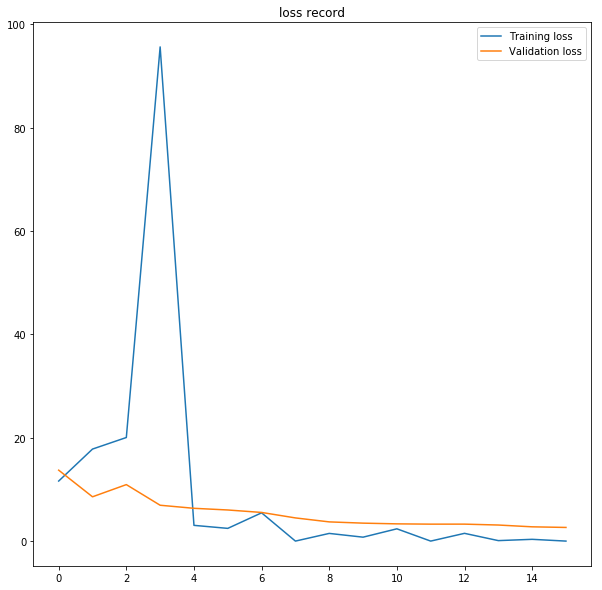

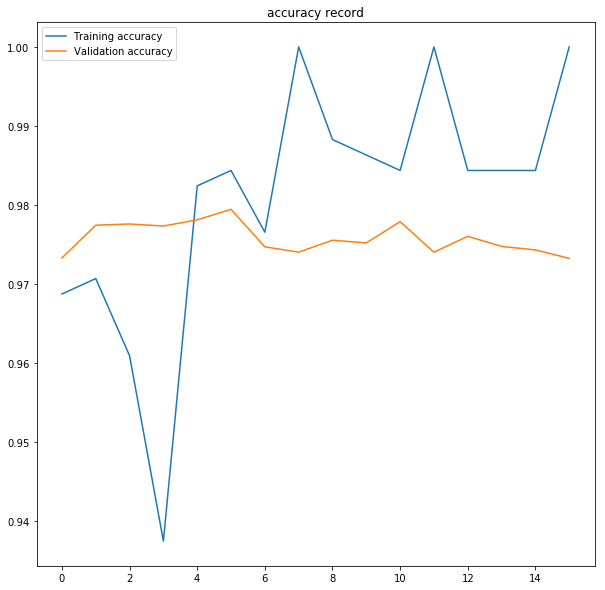

In [69]:
dog_vs_cat_vgg16_model.train(epochs = 20, batch_size = 512, re_train=True, keep_prob=0.5)

** FK! crazy better than what I did!!!! **

In [70]:
test_image_path = './test_image/'
test_image_list = os.listdir(test_image_path)

In [71]:
np.random.seed(10)

In [72]:
im_test = Image.open(test_image_path+test_image_list[np.random.randint(len(test_image_list))])

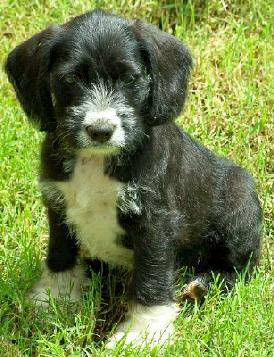

In [73]:
im_test

In [74]:
dog_vs_cat_vgg16_model.predict(np.array(im_test.resize((224, 224), Image.NEAREST)))

INFO:tensorflow:Restoring parameters from ./model/vgg_model/model.ckpt
it's a dog


# TODO

** use VGG19 to train it **

** use other model to train it **